In [1]:
import os
import numpy as np
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
AUDIO_DIR = 'audio_files/fma_small'

In [3]:
def get_tids_from_directory(audio_dir):
    """Get track IDs from the mp3s in a directory.
    Parameters
    ----------
    audio_dir : str
        Path to the directory where the audio files are stored.
    Returns
    -------
        A list of track IDs.
    """
    tids = []
    for _, dirnames, files in os.walk(audio_dir):
        if dirnames == []:
            tids.extend(int(file[:-4]) for file in files)
    return tids


def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'
    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

In [4]:
tids = get_tids_from_directory(AUDIO_DIR)
print(len(tids))

8000


### Function to create spectograms

In [5]:
def create_spectogram(track_id):
    filename = get_audio_path(AUDIO_DIR, track_id)
    y, sr = librosa.load(filename)
    spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
    return spect.T

In [6]:
def plot_spect(track_id):
    spect = create_spectogram(track_id)
    print(spect.shape)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spect.T, y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

(646, 128)


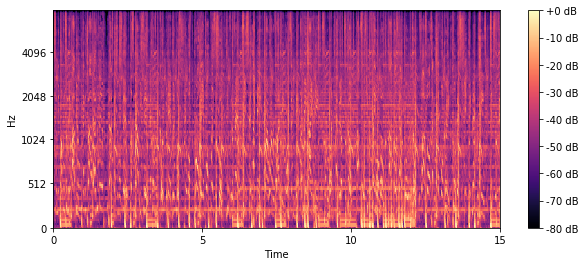

In [7]:
plot_spect(2)

### Load dataset with genre and track IDs

In [8]:
filepath = 'audio_files/tracks.csv'
tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])
keep_cols = [('set', 'split'),
('set', 'subset'),('track', 'genre_top')]

df_all = tracks[keep_cols]
df_all = df_all[df_all[('set', 'subset')] == 'small']

df_all['track_id'] = df_all.index

isElectronic = df_all[('track', 'genre_top')] == 'Electronic'
isRock = df_all[('track', 'genre_top')] == 'Rock'
isInstrumental = df_all[('track', 'genre_top')] == 'Instrumental'
isFolk = df_all[('track', 'genre_top')] == 'Folk'
filtered_df = df_all[isElectronic | isRock | isInstrumental | isFolk]

filtered_df.head()

set            track track_id
             split subset genre_top         
track_id                                    
140       training  small      Folk      140
141       training  small      Folk      141
182           test  small      Rock      182
190       training  small      Folk      190
193       training  small      Folk      193

In [46]:
df_all.shape

(8000, 4)

In [9]:
filtered_df.shape

(4000, 4)

In [10]:
filtered_df[('track', 'genre_top')].unique()

array(['Folk', 'Rock', 'Electronic', 'Instrumental'], dtype=object)

In [11]:
dict_genres = {'Electronic':1, 'Rock':2, 'Instrumental':3, 'Folk':4}

### Create Arrays

In [12]:
def create_array(df):
    genres = []
    X_spect = np.empty((0, 640, 128))
    count = 0
    #Code skips records in case of errors
    for index, row in df.iterrows():
        try:
            count += 1
            track_id = int(row['track_id'])
            genre = str(row[('track', 'genre_top')])
            spect = create_spectogram(track_id)

            # Normalize for small shape differences
            spect = spect[:640, :]
            X_spect = np.append(X_spect, [spect], axis=0)
            genres.append(dict_genres[genre])
            if count % 100 == 0:
                print("Currently processing: ", count)
        except:
            print("Couldn't process: ", count)
            continue
    y_arr = np.array(genres)
    return X_spect, y_arr

In [13]:
filtered_df[('set', 'split')].unique()

array(['training', 'test', 'validation'], dtype=object)

### Create train, validation and test subsets

In [14]:
df_train = filtered_df[filtered_df[('set', 'split')]=='training']
df_valid = filtered_df[filtered_df[('set', 'split')]=='validation']
df_test = filtered_df[filtered_df[('set', 'split')]=='test']

print(df_train.shape, df_valid.shape, df_test.shape)

(3200, 4) (400, 4) (400, 4)


In [15]:
X_test, y_test = create_array(df_test)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400


In [16]:
print(X_test.shape, y_test.shape)

(400, 640, 128) (400,)


In [17]:
print(y_test[:23])

[2 4 4 2 2 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [18]:
np.savez('test_arr', X_test, y_test)

In [19]:
X_valid, y_valid = create_array(df_valid)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400


In [20]:
np.savez('valid_arr', X_valid, y_valid)

#### Note: Train data split into 4 chunks to do the slow pre-processing in phases

In [21]:
def splitDataFrameIntoSmaller(df, chunkSize = 800): 
    listOfDf = list()
    numberChunks = len(df) // chunkSize + 1
    for i in range(numberChunks):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
    return listOfDf

In [22]:
listDf = splitDataFrameIntoSmaller(df_train)
df1_train = listDf[0]
df2_train = listDf[1]
df3_train = listDf[2]
df4_train = listDf[3]
print(df1_train.shape, df2_train.shape, df3_train.shape, df4_train.shape)

(800, 4) (800, 4) (800, 4) (800, 4)


In [23]:
X_train1, y_train1 = create_array(df1_train)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800


In [24]:
np.savez('train1_arr', X_train1, y_train1)

In [25]:
X_train2, y_train2 = create_array(df2_train)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Couldn't process:  686
Currently processing:  700
Currently processing:  800


In [26]:
np.savez('train2_arr', X_train2, y_train2)

In [27]:
X_train3, y_train3 = create_array(df3_train)

Currently processing:  100
Couldn't process:  115
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800


In [28]:
print(X_train3.shape, y_train3.shape)

(799, 640, 128) (799,)


In [29]:
np.savez('train3_arr', X_train3, y_train3)

In [30]:
X_train4, y_train4 = create_array(df4_train)

Currently processing:  100
Currently processing:  200
Currently processing:  300
Currently processing:  400
Currently processing:  500
Currently processing:  600
Currently processing:  700
Currently processing:  800


In [31]:
np.savez('train4_arr', X_train4, y_train4)

In [32]:
print(X_train4.shape, y_train4.shape)

(800, 640, 128) (800,)


### Concatenate and Shuffle data

In [33]:
npzfile = np.load('train1_arr.npz')
print(npzfile.files)
X_train1 = npzfile['arr_0']
y_train1 = npzfile['arr_1']
print(X_train1.shape, y_train1.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [34]:
npzfile = np.load('train2_arr.npz')
print(npzfile.files)
X_train2 = npzfile['arr_0']
y_train2 = npzfile['arr_1']
print(X_train2.shape, y_train2.shape)

['arr_0', 'arr_1']
(799, 640, 128) (799,)


In [35]:
npzfile = np.load('train3_arr.npz')
print(npzfile.files)
X_train3 = npzfile['arr_0']
y_train3 = npzfile['arr_1']
print(X_train3.shape, y_train3.shape)

['arr_0', 'arr_1']
(799, 640, 128) (799,)


In [36]:
npzfile = np.load('train4_arr.npz')
print(npzfile.files)
X_train4 = npzfile['arr_0']
y_train4 = npzfile['arr_1']
print(X_train4.shape, y_train4.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [37]:
npzfile = np.load('valid_arr.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(400, 640, 128) (400,)


#### Concatenate train data

In [38]:
X_train = np.concatenate((X_train1, X_train2, X_train3, X_train4), axis = 0)
y_train = np.concatenate((y_train1, y_train2, y_train3, y_train4), axis = 0)
print(X_train.shape, y_train.shape)

(3198, 640, 128) (3198,)


In [39]:
## Convert y data from scale 0-7
print(np.amin(X_train), np.amax(X_train), np.mean(X_train))
y_train = y_train -1
y_valid = y_valid -1
print(np.amin(y_train), np.amax(y_train), np.mean(y_train))

-80.0 0.0 -44.875285505332
0 3 1.5006253908692933


In [40]:
### Convert the scale of training data
X_train_raw = librosa.core.db_to_power(X_train, ref=1.0)
print(np.amin(X_train_raw), np.amax(X_train_raw), np.mean(X_train_raw))

1e-08 1.0 0.004669499660584291


In [41]:
X_train_log = np.log(X_train_raw)
print(np.amin(X_train_log), np.amax(X_train_log), np.mean(X_train_log))

-18.420680743952367 0.0 -10.332916344842992


In [42]:
X_valid_raw = librosa.core.db_to_power(X_valid, ref=1.0)
X_valid_log = np.log(X_valid_raw)

In [43]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X_train, y_train = unison_shuffled_copies(X_train_log, y_train)
X_valid, y_valid = unison_shuffled_copies(X_valid_log, y_valid)

In [44]:
print("Shapes are: ", X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

Shapes are:  (3198, 640, 128) (400, 640, 128) (3198,) (400,)


In [45]:
np.savez('shuffled_train', X_train, y_train)
np.savez('shuffled_valid', X_valid, y_valid)